In [27]:
import numpy as np
import random
import os

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

# Part 1 - Data Preprocessing

## Split into train , test data

In [28]:
# train, test split
splitfolders.ratio('./data/humanModel/imagesDatabase/', output="./data/humanModel/imagesDatabase_split", ratio=(0.7, 0.3))

Copying files: 6429 files [00:00, 13865.32 files/s]


### Preprocessing the Training set

In [29]:
batch_size = 64
IMG_SIZE = 10

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory('./data/humanModel/imagesDatabase_split/train',
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory('./data/humanModel/imagesDatabase_split/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 4498 images belonging to 5 classes.
Found 1931 images belonging to 5 classes.


## View some data

In [30]:
num_classes = 5

model = Sequential([
  layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

# model = Sequential([
#   layers.Conv2D(8, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
#   layers.Conv2D(16, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
#   layers.Conv2D(32, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
#   layers.Conv2D(64, 3, padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.5),
#   layers.Flatten(),
#   layers.Dense(32, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
#   layers.Dense(num_classes, activation='softmax')
# ])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 10, 10, 8)         392       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 16)        2064      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 8)           1160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200)              

In [33]:
epochs=150
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/150
71/71 [==============================] - 1s 13ms/step - loss: 1.6535 - accuracy: 0.2628 - val_loss: 1.5655 - val_accuracy: 0.2895
Epoch 2/150
71/71 [==============================] - 1s 11ms/step - loss: 1.4380 - accuracy: 0.4155 - val_loss: 1.2660 - val_accuracy: 0.5039
Epoch 3/150
71/71 [==============================] - 1s 11ms/step - loss: 1.2806 - accuracy: 0.5173 - val_loss: 1.1840 - val_accuracy: 0.5546
Epoch 4/150
71/71 [==============================] - 1s 11ms/step - loss: 1.2135 - accuracy: 0.5420 - val_loss: 1.0994 - val_accuracy: 0.6209
Epoch 5/150
71/71 [==============================] - 1s 12ms/step - loss: 1.1570 - accuracy: 0.5789 - val_loss: 1.0820 - val_accuracy: 0.6318
Epoch 6/150
71/71 [==============================] - 1s 12ms/step - loss: 1.1228 - accuracy: 0.5992 - val_loss: 1.0342 - val_accuracy: 0.6308
Epoch 7/150
71/71 [==============================] - 1s 11ms/step - loss: 1.0964 - accuracy: 0.6065 - val_loss: 0.9939 - val_accuracy: 0.6520
Epoch 

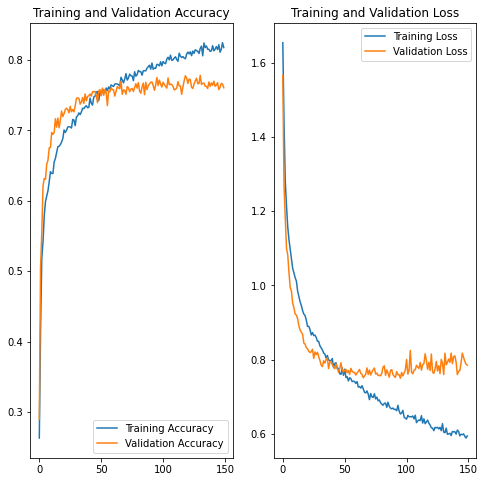

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

31/31 [==============================] - 0s 8ms/step - loss: 0.7848 - accuracy: 0.7607
Test accuracy : 0.7607457041740417


In [36]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/humanModel/model_v0.h5')

In [37]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [38]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [39]:
sunflower_path = "./data/humanModel/imagesDatabase_split/val/39/-MpIqdos7xbOmReSEoMh_10.png"

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(score), 100 * np.max(score))
)

This image most likely belongs to 3 with a 40.46 percent confidence.
